# 浅析最强RNN可微分神经计算机

神经网络在广泛的模式识别任务中表现良好。RNN可以以通过将“word states”转换为记忆向量处理诸如翻译，手写生成和语音识别之类的序列建模任务。但是在实践中RNN及主要变种LSTM处理长距离依赖序列需要大量的计算资源，且效果欠佳。理效果欠佳。为了解决这个问题，多种具有外存储机制的神经网络被设计出来，目前最具知名度的是Deepmind 的Differentiable Neural Computer (DNC) 。

通过把神经网络和可读写的外部存储器进行结合，可微分神经计算机（Differentiable Neural Computer，DNC）这种混合学习型神经网络，既能像神经网络那样进行学习，又能像计算机那样处理复杂数据。在发表于Nature的论文中，DNC是一种具有外存储器（不可训练）的特殊的循环神经网络。在每时间步t由可训练的控制器基于t-1 时刻的信息流与外存储器交换信息流之后线性输出预测。

![](NTM结构图1.png)

DNC使用向量(Vector)来存储记忆。存储器矩阵(Memory\ matrix)的每行对应于不同的记忆。通过使用控制器通过使用接口向量(Interface \ parameters)控制一个写头和多个读头（每个读头都是由两种寻址机制线性组合而成，读头数量在结构设计中未有约束）与外存储记忆交互。记忆矩阵$M \in \mathbb{R}^{N \times W} $一行W列表示一组记忆，N行表示记忆矩阵最多可以同时记忆多少组记忆。每个时间步DNC接受上一时刻读头信息流与此时刻信息流组成外部输入信息流（也就是传统LSTM对应每步外部输入input），经过处理发出隐藏状态，隐藏状态生成输出向量和接口向量。接口向量控制读写头与外存储矩阵交互，生成此时刻的写信息，并更新矩阵获得此时刻的读信息。读信息与输出向量线性组合生成此时刻最终输出向量。更新外存储器

$$
M_t = M_{t-1} \circ (E-\mathbf{w}_t^w \mathbf{e}_t^\intercal) + \mathbf{w}_t^w \mathbf{v}_t^\intercal\\
r_t^i = M_t^T w_t^{r,i}
$$
其中$E \in \mathbb{R}^{N \times W}$为全1矩阵；$w \in \mathbb{R}^N$为写头是归一化的分布权重；$\mathbf{e} \in \mathbb{R}^W$为擦除向量，取值局限于[0,1]之间；$\mathbf{v} \in \mathbb{R}^W$为写入记忆向量也就是此时刻新的记忆信息；注意读写头控制变量为记忆矩阵行与行之间的相对强度，而不是具体的记忆信息向量。从左向右，先擦除后写入。在此时刻记忆矩阵更新之后，读头提取此时刻记忆矩阵读头信息流$r_t$，该信息流线性组合此时刻最终输出并且作为下一时刻输入外部输入使用。
![](DNC_cell.PNG)

比较直观的看发表在Nature上的DNC相当于对LSTM添加一个外存储器，提高LSTM的记忆遗忘的问题。这篇论文里面构建了一个非常流畅的可微分的外记忆读写系统。如下图，在时间步t，control接收input vector $x_t$ 和上一个时间步记忆读取向量（读头$r_{t-1}$）以及control(LSTM的隐藏状态矩阵)进行计算处理之后，发出两个向量(ouput vector $v_t$  & interface vector $\xi_t$)。 其中$v_t$与读头$r_t$线性组合为最终输出向量$y_t$ 。$\xi_t$ 通过寻址机制Memory Addressing 与记忆矩阵$M$交互生成输出读头记忆$r_t$。

![](dnc_model.png)

control 通过发出接口向量控制access中write weighting 和read weightings的更新来控制记忆矩阵并得到读头读取的外部记忆向量。写头控制write weighting通过基于余弦相似性的内容寻址和基于写入频率和时间的使用情况usage确定记忆矩阵行位置的使用情况（根据先后写入和读取频率的程度信息决定被新记忆覆盖的顺序）。读头控制read weighting 通过基于余弦相似性的内容寻址和记忆矩阵行之间相对写入顺序更新读头控制。如下图，每时间步t，control接受上一时刻t-1读头记忆向量和此时刻外部输入作为时刻t的控制器输入信息流，在计算之后发出interface vector 控制外存储器更新写头，由写头控制擦除和写入更新记忆过程（图中绿色操作）。之后新的读头基于新记忆矩阵得到时刻t的读取记忆向量。时刻t得到读取记忆向量同控制器输出向量线性变换映射为时刻t的输出，并且读取记忆向量作为新的短期记忆传递向下一时刻t+1。DNC最终输出结果由时刻t得到读取记忆向量同控制器输出向量线性组合得到，类似于人脑的长期记忆和短期记忆Search of Associative Memory 模型，也就是每时间步的输出由短期记忆和长期记忆线性组合生成。

$$
\mathbf{y}_t = \mathcal{u}_t + W_r [\mathbf{r}_t^1; \ldots ;\mathbf{r}_t^R]
$$
![](DNC_cell.PNG)

## 附录：

### Controller

论文使用一个标准的LSTM模型。注意将工业界用的的LSTM公式组去掉batch_size，并设置hidden_num=1即为如下公式组书写形式。
$$
i_t^l = \sigma(W_i^l[\chi_t;h_{t-1}^l;h_t^{l-1}] + b_i^l)\\
f_t^l = \sigma(W_f^l[\chi_t;h_{t-1}^l;h_t^{l-1}] + b_f^l)\\
s_t^l = f_t^l s_{t-1}^l + i_t^l tanh (W_s^l[\chi_t;h_{t-1}^l;h_t^{l-1}] + b_s^l) \\
o_t^l = \sigma(W_o^l[\chi_t;h_{t-1}^l;h_t^{l-1}] + b_o^l)\\
h_t^l = o_t^ltanh(s_t^l)\\
\chi_t = [x_t;r_{t-1}^1;...;r_{t-1}^l]
$$

多层LSTM之间信息流动方向如下图：
![](Controller.jpg)

每时间步control最终输出的output \ vector 和interface vector 综合所有隐藏状态向量生成。
$$
\nu_t = W_y[h_t^l;...;h_t^l]\\
\varepsilon_t = W_{\varepsilon}[h_t^l;...;h_t^l]
$$

# 代码实现

In [1]:
import numpy as np
import tensorflow as tf

### Controller

In [2]:
class Controller(object):
    
    def __init__(self, hyperparameter):
        
        # 初始化 可训练权重矩阵
        weights_L1 = self._get_weights('layer_first', hyperparameter)
        weights_L2 = self._get_weights('layer_second', hyperparameter)
        weights_L3 = self._get_weights('layer_third', hyperparameter)
        weights_L4 = self._get_weights('layer_fourth', hyperparameter)
        
        hidden_num = hyperparameter['hidden_num']
        read_head_num = R = hyperparameter['read_head_num']
        out_width = hyperparameter['out_width']
        W = hyperparameter['memory_W']
        interface_width = R*W + 5*R + 3*W + 3
        weight_output = tf.get_variable('weight_output', shape=[hidden_num*4, out_width], dtype=tf.float32, initializer=tf.truncated_normal_initializer(0.01))
        weight_interface = tf.get_variable('weight_interface', shape=[hidden_num*4, interface_width], dtype=tf.float32, initializer=tf.truncated_normal_initializer(0.01))
        
        self.weights_trainable = (weights_L1, weights_L2, weights_L3, weights_L4, weight_output, weight_interface)
        
        
    def _get_weights(self, flag, hyperparameter):
        
        """
        weights_input: [in_width, hidden_num]
        weights_read_vectors_prev: [memory_W * read_head_num, hidden_num]
        weights_hidden_prev: [hidden_num, hidden_num]
        weights_hidden_lower: [hidden_num, hidden_num]
        biaes: [hidden_num]    
        """
        read_head_num = hyperparameter['read_head_num']
        in_width = hyperparameter['in_width']
        memory_W = hyperparameter['memory_W']
        hidden_num = hyperparameter['hidden_num']
        
        init = tf.truncated_normal_initializer(stddev=0.1)
        
        weights = {}

        # input_gate
        weights['input_gate_inputs'] = tf.get_variable(str(flag)+'input_gate_inputs', 
                                                       shape=[in_width, hidden_num], dtype=tf.float32, initializer=init)
        
        weights['input_gate_read_vectors_prev'] = tf.get_variable(str(flag)+'input_gate_read_vectors_prev', 
                                                                  shape=[memory_W*read_head_num, hidden_num], dtype=tf.float32, initializer=init)
        
        weights['input_gate_hidden_prev'] = tf.get_variable(str(flag)+'input_gate_hidden_prev', 
                                                            shape=[hidden_num, hidden_num], dtype=tf.float32, initializer=init)
        
        weights['input_gate_hidden_lower'] = tf.get_variable(str(flag)+'input_gate_hidden_lower', 
                                                             shape=[hidden_num, hidden_num], dtype=tf.float32, initializer=init)
        
        weights['input_gate_bias'] = tf.get_variable(str(flag)+'input_gate_bias', 
                                                     shape=[hidden_num], dtype=tf.float32, initializer=init)
        
        
        # forget_gate
        weights['forget_gate_inputs'] = tf.get_variable(str(flag)+'forget_gate_inputs', 
                                                        shape=[in_width, hidden_num], dtype=tf.float32, initializer=init)
        
        weights['forget_gate_read_vectors_prev'] = tf.get_variable(str(flag)+'forget_gate_read_vectors_prev', 
                                                                   shape=[memory_W*read_head_num, hidden_num], dtype=tf.float32, initializer=init)
        
        weights['forget_gate_hidden_prev'] = tf.get_variable(str(flag)+'forget_gate_hidden_prev', 
                                                             shape=[hidden_num, hidden_num], dtype=tf.float32, initializer=init)
        
        weights['forget_gate_hidden_lower'] = tf.get_variable(str(flag)+'forget_gate_hidden_lower', 
                                                              shape=[hidden_num, hidden_num], dtype=tf.float32, initializer=init)
        
        weights['forget_gate_bias'] = tf.get_variable(str(flag)+'forget_gate_bias', 
                                                      shape=[hidden_num], dtype=tf.float32, initializer=init)
        
        # state
        weights['state_inputs'] = tf.get_variable(str(flag)+'state_inputs', 
                                                  shape=[in_width, hidden_num], dtype=tf.float32, initializer=init)
        
        weights['state_read_vectors_prev'] = tf.get_variable(str(flag)+'state_read_vectors_prev', 
                                                             shape=[memory_W*read_head_num, hidden_num], dtype=tf.float32, initializer=init)
        
        weights['state_hidden_prev'] = tf.get_variable(str(flag)+'state_hidden_prev', 
                                                       shape=[hidden_num, hidden_num], dtype=tf.float32, initializer=init)
        
        weights['state_hidden_lower'] = tf.get_variable(str(flag)+'state_hidden_lower', 
                                                        shape=[hidden_num, hidden_num], dtype=tf.float32, initializer=init)
        
        weights['state_bias'] = tf.get_variable(str(flag)+'state_bias', 
                                                shape=[hidden_num], dtype=tf.float32, initializer=init)
        
        # output_gate
        weights['output_gate_inputs'] = tf.get_variable(str(flag)+'output_gate_inputs', 
                                                        shape=[in_width, hidden_num], dtype=tf.float32, initializer=init)
        
        weights['output_gate_read_vectors_prev'] = tf.get_variable(str(flag)+'output_gate_read_vectors_prev', 
                                                                   shape=[memory_W*read_head_num, hidden_num], dtype=tf.float32, initializer=init)
        
        weights['output_gate_hidden_prev'] = tf.get_variable(str(flag)+'output_gate_hidden_prev', 
                                                             shape=[hidden_num, hidden_num], dtype=tf.float32, initializer=init)
        
        weights['output_gate_hidden_lower'] = tf.get_variable(str(flag)+'output_gate_hidden_lower', 
                                                              shape=[hidden_num, hidden_num], dtype=tf.float32, initializer=init)
        
        weights['output_gate_bias'] = tf.get_variable(str(flag)+'output_gate_bias', 
                                                      shape=[hidden_num], dtype=tf.float32, initializer=init)
        
        return weights    
    
    
    def _element(self, inputs, read_vectors_prev, hidden_prev, hidden_lower, state_prev, weights):
        
        """
        inputs: [batch_size, in_width]
        * read_vectors_prev: [batch_size, memory_W * read_head_num]
        hidden_prev: [batch_size, hidden_num]
        hidden_lower: [batch_size, hidden_num]
        state_prev: [batch_size, hidden_num]
         
        weights_input: [in_width, hidden_num]
        weights_read_vectors_prev: [memory_W * read_head_num, hidden_num]
        weights_hidden_prev: [hidden_num, hidden_num]
        weights_hidden_lower: [hidden_num, hidden_num]
        biaes: [hidden_num]    
        
        input_gate: [batch_size, hidden_num]
        forget_gate: [batch_size, hidden_num]
        state: [batch_size. hidden_num]
        output_gate: [batch_size, hidden_num]
        hidden: [batch_size, hidden_num]
        """               
        
        input_gate = tf.nn.sigmoid(tf.matmul(inputs, weights['input_gate_inputs']) + 
                                   tf.matmul(read_vectors_prev, weights['input_gate_read_vectors_prev']) + 
                                   tf.matmul(hidden_prev, weights['input_gate_hidden_prev']) + 
                                   tf.matmul(hidden_lower, weights['input_gate_hidden_lower']) + 
                                   weights['input_gate_bias'])        

        forget_gate = tf.nn.sigmoid(tf.matmul(inputs, weights['forget_gate_inputs']) + 
                                    tf.matmul(read_vectors_prev, weights['forget_gate_read_vectors_prev']) + 
                                    tf.matmul(hidden_prev, weights['forget_gate_hidden_prev']) + 
                                    tf.matmul(hidden_lower, weights['forget_gate_hidden_lower']) + 
                                    weights['forget_gate_bias'])        
        
        state = tf.multiply(forget_gate, state_prev) + \
        tf.multiply(input_gate, tf.tanh(tf.matmul(inputs, weights['state_inputs']) + 
                                        tf.matmul(read_vectors_prev, weights['state_read_vectors_prev']) + 
                                        tf.matmul(hidden_prev, weights['state_hidden_prev']) + 
                                        tf.matmul(hidden_lower, weights['state_hidden_lower']) + 
                                        weights['state_bias']))
        
        output_gate = tf.nn.sigmoid(tf.matmul(inputs, weights['output_gate_inputs']) + 
                                    tf.matmul(read_vectors_prev, weights['output_gate_read_vectors_prev']) + 
                                    tf.matmul(hidden_prev, weights['output_gate_hidden_prev']) + 
                                    tf.matmul(hidden_lower, weights['output_gate_hidden_lower']) + 
                                    weights['output_gate_bias'])  
        
        hidden = tf.multiply(output_gate, state)
        
        return hidden, state
    

    def _unit(self, inputs, read_vectors_prev, tape):    
        
        # Trainable weight parameter
        weights_L1, weights_L2, weights_L3, weights_L4, weight_output, weight_interface = self.weights_trainable
        
        # Variables looping
        hidden_L1_prev, hidden_L1_lower, state_L1_prev,\
        hidden_L2_prev, state_L2_prev,\
        hidden_L3_prev, state_L3_prev,\
        hidden_L4_prev, state_L4_prev = tape
        
        # input layer
        hidden_L1, state_L1 = self._element(inputs, read_vectors_prev, hidden_L1_prev, hidden_L1_lower, state_L1_prev, weights_L1)
        
        # primary thinking layer
        hidden_L2_lower = hidden_L1
        hidden_L2, state_L2 = self._element(inputs, read_vectors_prev, hidden_L2_prev, hidden_L2_lower, state_L2_prev, weights_L2)
        
        # advanced thinking layer
        hidden_L3_lower = hidden_L2
        hidden_L3, state_L3 = self._element(inputs, read_vectors_prev, hidden_L3_prev, hidden_L3_lower, state_L3_prev, weights_L3)
        
        # output layer
        hidden_L4_lower = hidden_L3
        hidden_L4, state_L4 = self._element(inputs, read_vectors_prev, hidden_L4_prev, hidden_L4_lower, state_L4_prev, weights_L4)
        
        """
        hidden: [batch_size, hidden_num]
        hiddens: [batch_size, hidden_num * layers=4]
        
        weight_output: [4 * hidden_num, out_width]
        weight_interface: [4 * hidden_num, W*R+5R+3W+3]
        
        output_vector: [batch_size, out_width]
        interface_vector: [batch_size, W*R+5R+3W+3]
        """
        hiddens = tf.concat([hidden_L1, hidden_L2, hidden_L3, hidden_L4], axis=1)       
        output_vector = tf.matmul(hiddens, weight_output)
        interface_vector = tf.matmul(hiddens, weight_interface)   
        
        # Variables looping
        tape = (hidden_L1, hidden_L1_lower, state_L1,\
        hidden_L2, state_L2,\
        hidden_L3, state_L3,\
        hidden_L4, state_L4)        
        
        return tape, interface_vector, output_vector
    
    
    def step(self, inputs, read_vectors_prev, tape):
        tape, interface_vector, output_vector = self._unit(inputs, read_vectors_prev, tape)
        return tape, interface_vector, output_vector   


    def zero_state(self, hyperparameter):
        
        batch_size = hyperparameter['batch_size']
        hidden_num = hyperparameter['hidden_num']
        
        hidden_L1_prev = tf.zeros([batch_size, hidden_num], dtype=tf.float32)
        hidden_L0 = tf.zeros([batch_size, hidden_num], dtype=tf.float32)
        state_L1_prev = tf.zeros([batch_size, hidden_num], dtype=tf.float32)
        
        hidden_L2_prev = tf.zeros([batch_size, hidden_num], dtype=tf.float32)
        state_L2_prev = tf.zeros([batch_size, hidden_num], dtype=tf.float32)

        hidden_L3_prev = tf.zeros([batch_size, hidden_num], dtype=tf.float32)
        state_L3_prev = tf.zeros([batch_size, hidden_num], dtype=tf.float32)

        hidden_L4_prev = tf.zeros([batch_size, hidden_num], dtype=tf.float32)
        state_L4_prev = tf.zeros([batch_size, hidden_num], dtype=tf.float32)                

        tape = (hidden_L1_prev, hidden_L0, state_L1_prev,\
                hidden_L2_prev, state_L2_prev,\
                hidden_L3_prev, state_L3_prev,\
                hidden_L4_prev, state_L4_prev)
        
        return tape    

### Memory Addressing

In [3]:
class Memory_Addressing(object):
    
    def __init__(self, batch_size, memory_N):
        self.batch_size = batch_size
        self.memory_N = memory_N
        self.mask_eye = 1 - tf.eye(memory_N) 
        self.flat_shift = tf.constant(value= np.arange(self.batch_size)*self.memory_N, dtype=tf.int32, shape=[self.batch_size,1])
        self.eps = 1e-6

    # 余弦相似性的内容寻址
    def _Content_based_addressing(self, memory_matrix, lookup_key, key_strength):
        """
        memory_matrix: [batch_size, memory_N, memory_W]
        lookup_key: [batch_size, memory_W, read_head_num or write_head_num]
        key_strength: [batch_size, read_head_num or write_head_num] -> [batch_size, 1, read_head_num or write_head_num] 
        cosine_similarity: [batch_size, memory_N, read_head_num or write_head_num]
        content_weighting: [batch_size, memory_N, read_head_num or write_head_num]
        """
        # 计算余弦相似性 点乘数量积
        cosine_similarity = tf.matmul(tf.nn.l2_normalize(memory_matrix, dim=2), tf.nn.l2_normalize(lookup_key, dim=1))
        content_weighting = tf.nn.softmax(tf.multiply(cosine_similarity, tf.expand_dims(key_strength, axis=1)), dim=1)
        return content_weighting
    
    # 动态内存分配，retention_vector 根据所有读头反馈决定memory_matrix 矩阵索引memory_N的不被释放的程度    
    def _Dynamic_memory_allocation(self, free_gates, read_weightings_prev, write_weighting_prev, usage_vector_prev):
        """
        * free_gates: [batch_size, read_head_num] -> [batch_size, 1, read_head_num]       
        read_weightings_prev: [batch_size, memory_N, read_head_num]
        retention_vector: [batch_size, memory_N]
        
        write_weighting_prev: [batch_size, memory_N]
        usage_vector_prev: [batch_size, memory_N]
        usage_vector: [batch_size, memory_N]

        allocation_weighting: [batch_size, memory_N]
        
        Note: * read_weightings_prev: [batch_size, memory_N, read_head_num]
              * write_weighting_prev: [batch_size, memory_N]
        """
        free_gates = tf.expand_dims(free_gates, axis=1)
        retention_vector = tf.reduce_prod(1 - tf.multiply(read_weightings_prev, free_gates), axis=2)       
        
        usage_vector = tf.multiply((usage_vector_prev + write_weighting_prev - tf.multiply(usage_vector_prev, write_weighting_prev)), retention_vector)
        
        values, indices = tf.nn.top_k(usage_vector, k=self.memory_N)  # 降序排列    
        values_sorted = tf.reverse(values, axis=[1]) # 值 升序
        indices_sorted = tf.reverse(indices, axis=[1]) # 索引 升序
        allocation_weighting = tf.multiply((1-values_sorted), tf.cumprod(values_sorted, axis=1, exclusive=True))
        """
        allocation_weighting 值返回原始位置
        这里根据论文计算的公式论文里面使用的索引计算方式，也就是按索引顺序的计算得出上面的矩阵，还需要返回正常的顺序。
        通过TensorArray操作将allocation_weighting 返回原来的序列，也就是usage_vector 最初对应的序列，也就是memory 矩阵的正常序列，
        返回的数值为根据 allocation_weighting 计算的释放程度的值
        """
        indices_flat = tf.reshape(tensor= indices_sorted + self.flat_shift, shape=[-1])
        flat_array = tf.TensorArray(dtype=tf.float32, size=self.batch_size*self.memory_N)
        scatter= flat_array.scatter(indices= indices_flat, value= tf.reshape(allocation_weighting, shape=[-1]))
        allocation_sort_undo = scatter.stack()
        allocation_weighting = tf.reshape(allocation_sort_undo, shape=[self.batch_size, self.memory_N])     
        allocation_weighting = tf.stop_gradient(allocation_weighting)
        #usage_vector = tf.stop_gradient(usage_vector)
        return allocation_weighting, usage_vector
    
    # 更新写头分布权重
    def _Write_weighting(self, memory_matrix_prev, write_key, write_strength, 
                         free_gates, read_weightings_prev, write_weighting_prev, usage_vector_prev, 
                         allocation_gate, write_gate):
        """
        memory_matrix_prev: [batch_size, memory_N, memory_W]
        write_key: [batch_size, memory_W, write_head_num= 1]
        write_strength: [batch_size, 1]
        * write_content_weighting: [batch_size, memory_N, 1] -> write_content_weighting: [batch_size, memory_N]

        free_gates: [batch_size, read_head_num] ->  [batch_size, 1, read_head_num]       
        read_weightings_prev: [batch_size, memory_N, read_head_num]
        write_weighting_prev: [batch_size, memory_N]
        usage_vector_prev: [batch_size, memory_N]
        allocation_weighting: [batch_size, memory_N]
        usage_vector: [batch_size, memory_N]

        allocation_gate: [batch_size, 1]
        write_gate: [batch_size, 1]        
        write_weighting: [batch_size, memory_N]
        """
        write_content_weighting = tf.squeeze(self._Content_based_addressing(memory_matrix_prev, write_key, write_strength), axis=[2])
        allocation_weighting, usage_vector = self._Dynamic_memory_allocation(free_gates, read_weightings_prev, write_weighting_prev, usage_vector_prev)
        write_weighting = tf.multiply((tf.multiply(allocation_weighting, allocation_gate) + tf.multiply(write_content_weighting, (1-allocation_gate))), write_gate)
        return write_weighting, usage_vector 
    
    
    # 时间记忆链
    def _Temporal_memory_linkage(self, write_weighting, precedence_weighting_prev, 
                                link_matrix_prev, 
                                read_weightings_prev):        
        """
        write_weighting: [batch_size, memory_N]
        precedence_weighting_prev: [batch_size, memory_N]
        precedence_weighting: [batch_size, memory_N]
        
        * write_weighting: [batch_size, memory_N] -> write_weighting: [batch_size, memory_N, 1]
        tmp: [batch_size, memory_N, memory_N]
        link_marix_prev: [batch_size, memory_N, memory_N]
        left: [batch_size, memory_N, memory_N]
        * precedence_weighting_fit: [batch_size, memory_N] -> precedence_weighting: [batch_size, 1, memory_N] 维度匹配
        right: [batch_size, memory_N, memory_N]
        link_marix: [batch_size, memory_N, memory_N]
        
        read_weightings_prev: [batch_size, memory_N, read_head_num]
        forward_weighting: [batch_size, memory_N, read_head_num]
        backward_weighting: [batch_size, memory_N, read_head_num]
        """
        
        precedence_weighting = tf.multiply(precedence_weighting_prev, (1 - tf.reduce_sum(write_weighting, axis=1, keep_dims=True))) + write_weighting
        
        write_weighting = tf.expand_dims(write_weighting, axis=2)
        tmp = tf.tile(write_weighting, multiples=[1,1,self.memory_N])
        left = tf.multiply(link_matrix_prev, (1 - tmp - tf.transpose(tmp,perm=[0,2,1])))
        precedence_weighting_fit = tf.expand_dims(precedence_weighting_prev, axis=1) # 维度匹配
        right = tf.matmul(write_weighting, precedence_weighting_fit)        
        link_matrix = tf.multiply((left+right), self.mask_eye) # 掩码处理对角线消除

        forward_weighting = tf.matmul(link_matrix, read_weightings_prev)
        backward_weighting = tf.matmul(link_matrix, read_weightings_prev, transpose_a=True)

        return forward_weighting, backward_weighting, link_matrix, precedence_weighting
    
    
    # 更新读头权重参数
    def _Read_weighting(self, memory_matrix, read_keys, read_strengths, 
                        write_weighting, precedence_weighting_prev, 
                        link_matrix_prev, 
                        read_weightings_prev, 
                        read_modes):
        
        """
        memory_matrix: [batch_size, memory_N, memory_W]
        read_keys: [batch_size, memory_N, read_head_num]
        read_strengths: [batch_size, read_head_num]
        read_content_weighting: [batch_size, memory_N, read_head_num]
        
        write_weighting: [batch_size, memory_N] 
        precedence_weighting_prev: [batch_size, memory_N]
        link_marix_prev: [batch_size, memory_N, memory_N]
        read_weightings_prev: [batch_size, memory_N, read_head_num]
        forward_weighting: [batch_size, memory_N, read_head_num]
        backward_weighting: [batch_size, memory_N, read_head_num]
        link_marix: [batch_size, memory_N, memory_N]
        precedence_weighting: [batch_size, memory_N] 
        
        read_modes: [batch_size, 3, read_head_num]
        forward: [batch_size, memory_N, read_head_num]
        backward: [batch_size, memory_N, read_head_num]
        content: [batch_size, memory_N, read_head_num]
        
        read_weightings: [batch_size, memory_N, read_head_num]
        """
        read_content_weightings = self._Content_based_addressing(memory_matrix, read_keys, read_strengths)
        
        forward_weighting, backward_weighting, link_matrix, precedence_weighting = \
        self._Temporal_memory_linkage(write_weighting, precedence_weighting_prev, link_matrix_prev, read_weightings_prev)

        backward = tf.multiply(backward_weighting, tf.expand_dims(read_modes[:,0,:], axis=1))
        content = tf.multiply(read_content_weightings, tf.expand_dims(read_modes[:,1,:], axis=1))
        forward = tf.multiply(forward_weighting, tf.expand_dims(read_modes[:,2,:], axis=1))
        read_weightings = backward + content + forward
        return read_weightings, precedence_weighting, link_matrix

### 外部缓存交互

In [4]:
class External_Cache(Memory_Addressing):
    
    def __init__(self, hyperparameter):
        Memory_Addressing.__init__(self, hyperparameter['batch_size'], hyperparameter['memory_N'])
        self.memory_W = hyperparameter['memory_W']
        self.read_head_num = hyperparameter['read_head_num']
        
        
    def _Interface_parameters(self, interface_vector):
        # 处理控制器发出接口向量
        """
        interface_vector: [batch_size, W*R+5R+3W+3]
        
        * read_keys: [batch_size, memory_W * read_head_num] -> [batch_size, memory_W, read_head_num]
        read_strengths: [batch_size, read_head_num]
        * write_key: [batch_size, memory_W] -> [batch_size, memory_W, write_head_num=1]
        write_strengths: [batch_size, write_head_num=1]
        erase_vector: [batch_size, memory_W]
        write_vector: [batch_size, memory_W]
        free_gates: [batch_size, read_head_num]
        allocation_gate: [batch_size, 1]
        write_gate: [batch_size, 1]
        * read_modes: [batch_size, 3 * read_head_num] -> [batch_size, 3, read_head_num]
        """
        R,W = self.read_head_num, self.memory_W        
        splits = np.cumsum([0,W*R,R,W,1,W,W,R,1,1,3*R])        
        tmp_list = [interface_vector[:, splits[i]:splits[i+1]] for i in range(len(splits)-1)]
        
        read_keys = tf.reshape(tmp_list[0], shape=[-1, self.memory_W, self.read_head_num])
        read_strengths = 1 + tf.nn.softplus(tf.reshape(tmp_list[1], shape=[-1, self.read_head_num]))
        write_key = tf.reshape(tmp_list[2], shape=[-1, self.memory_W, 1])
        write_strength = 1 + tf.nn.softplus(tf.reshape(tmp_list[3], shape=[-1,1]))
        erase_vector = tf.nn.sigmoid(tf.reshape(tmp_list[4], shape=[-1, self.memory_W]))
        write_vector = tf.reshape(tmp_list[5], shape=[-1, self.memory_W])
        free_gates = tf.nn.sigmoid(tf.reshape(tmp_list[6], shape=[-1, self.read_head_num]))
        allocation_gate = tf.nn.sigmoid(tmp_list[7])        
        write_gate = tf.nn.sigmoid(tmp_list[8])
        read_modes = tf.nn.softmax(tf.reshape(tmp_list[9], shape=[-1, 3, self.read_head_num]))        
        

    def _reading_and_writing_to_memory(self, tape, interface_vector):

        # 处理控制器发出接口向量
        """
        interface_vector: [batch_size, W*R+5R+3W+3]
        
        * read_keys: [batch_size, memory_W * read_head_num] -> [batch_size, memory_W, read_head_num]
        read_strengths: [batch_size, read_head_num]
        * write_key: [batch_size, memory_W] -> [batch_size, memory_W, write_head_num=1]
        write_strengths: [batch_size, write_head_num=1]
        erase_vector: [batch_size, memory_W]
        write_vector: [batch_size, memory_W]
        free_gates: [batch_size, read_head_num]
        allocation_gate: [batch_size, 1]
        write_gate: [batch_size, 1]
        * read_modes: [batch_size, 3 * read_head_num] -> [batch_size, 3, read_head_num]
        """
        R,W = self.read_head_num, self.memory_W        
        splits = np.cumsum([0,W*R,R,W,1,W,W,R,1,1,3*R])        
        tmp_list = [interface_vector[:, splits[i]:splits[i+1]] for i in range(len(splits)-1)]
        
        read_keys = tf.reshape(tmp_list[0], shape=[-1, self.memory_W, self.read_head_num])
        read_strengths = 1 + tf.nn.softplus(tf.reshape(tmp_list[1], shape=[-1, self.read_head_num]))
        write_key = tf.reshape(tmp_list[2], shape=[-1, self.memory_W, 1])
        write_strength = 1 + tf.nn.softplus(tf.reshape(tmp_list[3], shape=[-1,1]))
        erase_vector = tf.nn.sigmoid(tf.reshape(tmp_list[4], shape=[-1, self.memory_W]))
        write_vector = tf.reshape(tmp_list[5], shape=[-1, self.memory_W])
        free_gates = tf.nn.sigmoid(tf.reshape(tmp_list[6], shape=[-1, self.read_head_num]))
        allocation_gate = tf.nn.sigmoid(tmp_list[7])        
        write_gate = tf.nn.sigmoid(tmp_list[8])
        read_modes = tf.nn.softmax(tf.reshape(tmp_list[9], shape=[-1, 3, self.read_head_num]))        
        
        # 处理循环数据
        """
        memory_matrix_prev: [batch_size, memory_N, memory_W]
        read_weightings_prev: [batch_size, memory_N, read_head_num]
        write_weighting_prev: [batch_size, memory_N]
        usage_vector_prev: [batch_size, memory_N]
        link_marix_prev: [batch_size, memory_N, memory_N]
        precedence_weighting_prev: [batch_size, memory_N]
        """  
        memory_matrix_prev = tape[0]
        read_weightings_prev = tape[1]
        write_weighting_prev = tape[2]
        usage_vector_prev = tape[3]
        link_matrix_prev = tape[4]
        precedence_weighting_prev = tape[5]
        
        # Memory addressing -> write weighting       
        """
        memory_matrix_prev: [batch_size, memory_N, memory_W]
        write_key: [batch_size, memory_W, write_head_num=1]
        write_strengths: [batch_size, write_head_num=1]
        
        free_gates: [batch_size, read_head_num]
        read_weightings_prev: [batch_size, memory_N, read_head_num]
        write_weighting_prev: [batch_size, memory_N]
        usage_vector_prev: [batch_size, memory_N]
        
        allocation_gate: [batch_size, 1]
        write_gate = tf.nn.sigmoid(tmp_list[8])
        
        write_weighting: [batch_size, memory_N]
        usage_vector: [batch_size, memory_N]
        """
        write_weighting, usage_vector = self._Write_weighting(memory_matrix_prev, write_key, write_strength, 
                                                              free_gates, read_weightings_prev, write_weighting_prev, usage_vector_prev,
                                                              allocation_gate, write_gate)
        
        
        # reading and writing to memory -> update memory
        """
        write_weighting: [batch_size, memory_N]
        * write_weighting_fit: [batch_size, memory_N] -> write_weighting: [batch_size, memory_N, 1]
        erase_vector: [batch_size, memory_W] -> erase_vector: [batch_size, 1, memory_W]
        write_vector: [batch_size, memory_W] -> write_vector: [batch_size, 1, memory_W]
        
        memory_matrix_prev: [batch_size, memory_N, memory_W]
        """
        write_weighting_fit = tf.expand_dims(write_weighting, axis=2)
        erase_vector = tf.expand_dims(erase_vector, axis=1)
        write_vector = tf.expand_dims(write_vector, axis=1)
        
        erase_operation = tf.multiply(memory_matrix_prev, (1-tf.matmul(write_weighting_fit, erase_vector)))
        write_operation = tf.matmul(write_weighting_fit, write_vector)
        memory_matrix = erase_operation + write_operation        
        
        # memory addressing -> read weightings
        """
        memory_matrix: [batch_size, memory_N, memory_W]
        read_keys: [batch_size, memory_W , read_head_num]
        read_strengths: [batch_size, read_head_num]
        precedence_weighting_prev: [batch_size, memory_N]
        link_marix_prev: [batch_size, memory_N, memory_N]
        read_modes: [batch_size, 3 * read_head_num]
        read_weightings: [batch_size, memory_N, read_head_num]
        precedence_weighting: [batch_size, memory_N]
        link_marix: [batch_size, memory_N, memory_N]
        
        read_vectors: [batch_size, memory_W, read_head_num] 
        """

        read_weighting, precedence_weighting, link_matrix = \
        self._Read_weighting(memory_matrix, 
                             read_keys, read_strengths, 
                             write_weighting, precedence_weighting_prev, 
                             link_matrix_prev,
                             read_weightings_prev,
                             read_modes)      
        
        read_vectors = tf.matmul(memory_matrix, read_weighting, adjoint_a=True)

        # 处理循环数据        
        tape = (memory_matrix, read_weighting, write_weighting, usage_vector, link_matrix, precedence_weighting)
        # 处理输出数据 read_vectors: [batch_size, memory_W, read_head_num] -> [batch_size, memory_W * read_head_num]
        read_vectors = tf.reshape(read_vectors, shape=[-1, R*W])
        return tape, read_vectors
    
    
    def step(self, tape, interface_vector):
        tape, read_vectors = self._reading_and_writing_to_memory(interface_vector=interface_vector, tape=tape)
        return tape, read_vectors       
    
        
    def zero_state(self):        
        """
        memory_matrix_prev: [batch_size, memory_N, memory_W]
        read_weightings_prev: [batch_size, memory_N, read_head_num]
        write_weighting_prev: [batch_size, memory_N]
        usage_vector_prev: [batch_size, memory_N]
        link_marix_prev: [batch_size, memory_N, memory_N]
        precedence_weighting_prev: [batch_size, memory_N]
        """
        return (tf.fill(dims=[self.batch_size, self.memory_N, self.memory_W], value=self.eps), 
                tf.fill(dims=[self.batch_size, self.memory_N, self.read_head_num], value=self.eps),
                tf.fill(dims=[self.batch_size, self.memory_N], value=self.eps),
                tf.zeros([self.batch_size, self.memory_N]),
                tf.zeros([self.batch_size, self.memory_N, self.memory_N]),
                tf.zeros([self.batch_size, self.memory_N]))

### DNC封装

In [5]:
class DNC_Seq2Seq(object):
    
    def __init__(self, inputs, targets, hyperparameter):
        self.inputs = inputs
        self.targets = targets
        self.hyperparameter = hyperparameter
        
        self.Controller = Controller(hyperparameter)
        self.Cache = External_Cache(hyperparameter)
        self.inputs_placeholder = tf.placeholder(dtype=tf.float32, shape=[hyperparameter['batch_size'], hyperparameter['in_length'], hyperparameter['in_width']])
        self.targets_placeholder = tf.placeholder(dtype=tf.float32, shape=[hyperparameter['batch_size'], hyperparameter['out_length'], hyperparameter['out_width']])
        self.weight_read_vectors = tf.get_variable('weight_read_vector',\
                                                   shape=[hyperparameter['memory_W'] * hyperparameter['read_head_num'], hyperparameter['out_width']],\
                                                   dtype = tf.float32, initializer = tf.truncated_normal_initializer(0.01))

    def _step(self, tape, inputs):
        
        tape_controller, tape_cache, read_vectors_prev, linear_prev = tape
        
        tape_controller, interface_vector, output_vector = self.Controller.step(inputs, read_vectors_prev, tape_controller)
        tape_cache, read_vectors = self.Cache.step(tape_cache, interface_vector)
        linear = output_vector + tf.matmul(read_vectors, self.weight_read_vectors)        
        
        return (tape_controller, tape_cache, read_vectors, linear)    
    
    
    def _zero_state(self, hyperparameter):    
        tape_controller = self.Controller.zero_state(hyperparameter)
        tape_cache = self.Cache.zero_state()
        read_vectors_prev = tf.zeros([hyperparameter['batch_size'], hyperparameter['memory_W'] * hyperparameter['read_head_num']], dtype=tf.float32)
        linear_prev = tf.zeros([hyperparameter['batch_size'], hyperparameter['out_width']], dtype=tf.float32)
        
        return (tape_controller, tape_cache, read_vectors_prev, linear_prev)      
    
    def fit(self):
        raise NotImplementedError("fit does not exist")
        
    def pred(self):
        raise NotImplementedError("pred does not exist")


### 生成训练数据

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

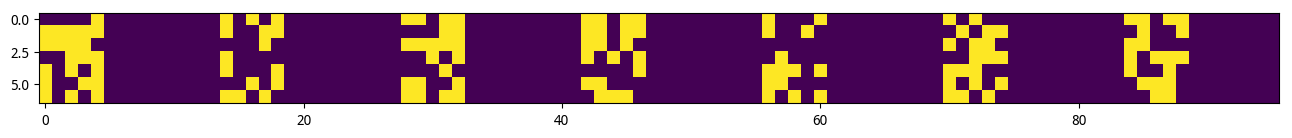

In [7]:
step_length = 5
in_width = 7
repetitions = 7

A = [np.concatenate((np.random.randint(low=0, high=2, size=(step_length, in_width)), np.zeros(shape=[step_length+4, in_width])), axis=0) for _ in range(repetitions)]
A = np.vstack(A)[:-2,:]
B = np.vstack([A[-step_length-2:,:],A[:-step_length-2]])

plt.figure(figsize=(16,8))
plt.imshow(A.T, interpolation='none')
plt.show()

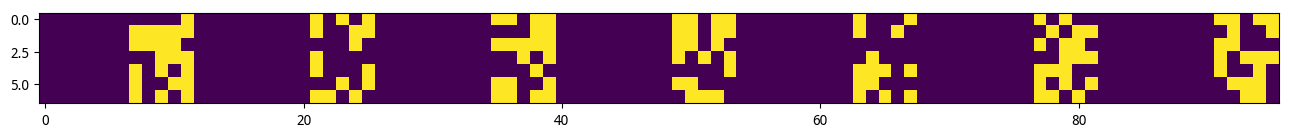

In [8]:
plt.figure(figsize=(16,8))
plt.imshow(B.T, interpolation='none')
plt.show()

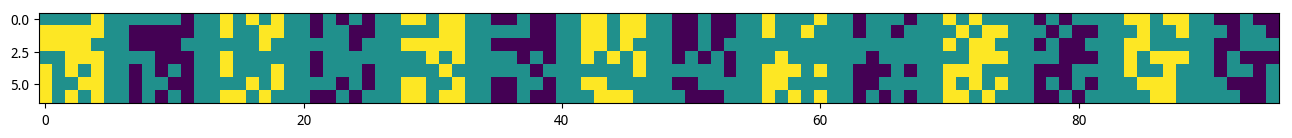

In [9]:
plt.figure(figsize=(16,8))
plt.imshow(A.T- B.T, interpolation='none')
plt.show()

### 批次数据

In [10]:
def sequence_generation(step_length= 5, in_width= 7, repetitions= 7):
    A = [np.concatenate((np.random.randint(low=0, high=2, size=(step_length, in_width)), np.zeros(shape=[step_length+4, in_width])), axis=0) for _ in range(repetitions)]
    A = np.vstack(A)[:-2,:]
    B = np.vstack([A[-step_length-2:,:],A[:-step_length-2]])
    return A, B

def batch_generation(batch_size=32, step_length=11, in_width= 13, repetitions= 3):
    A_batch = []
    B_batch = []
    for _ in range(batch_size):
        A, B = sequence_generation(step_length, in_width, repetitions)
        A_batch.append(A)
        B_batch.append(B)
    
    A_tensor = np.transpose(np.dstack(A_batch), axes=[2,0,1])
    B_tensor = np.transpose(np.dstack(B_batch), axes=[2,0,1])
    return A_tensor, B_tensor

train_inputs, train_targets = batch_generation()
test_inputs, test_targets = batch_generation()

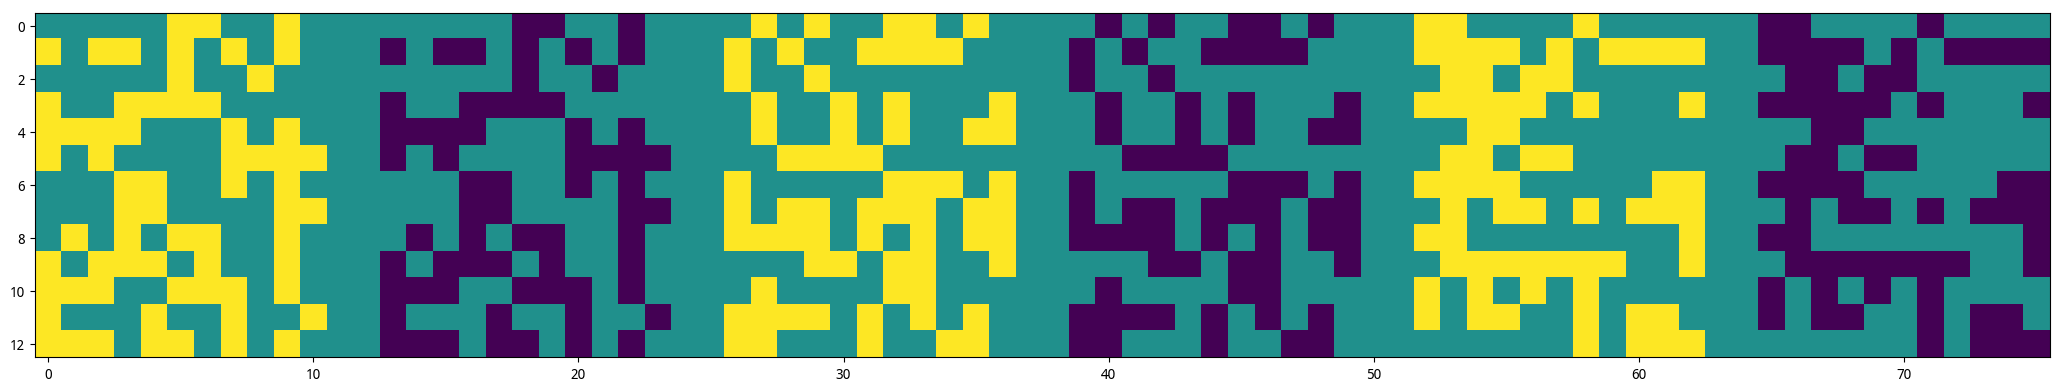

In [11]:
plt.figure(figsize=(26,8))
plt.imshow(train_inputs[0].T-train_targets[0].T, interpolation='none')
plt.show()

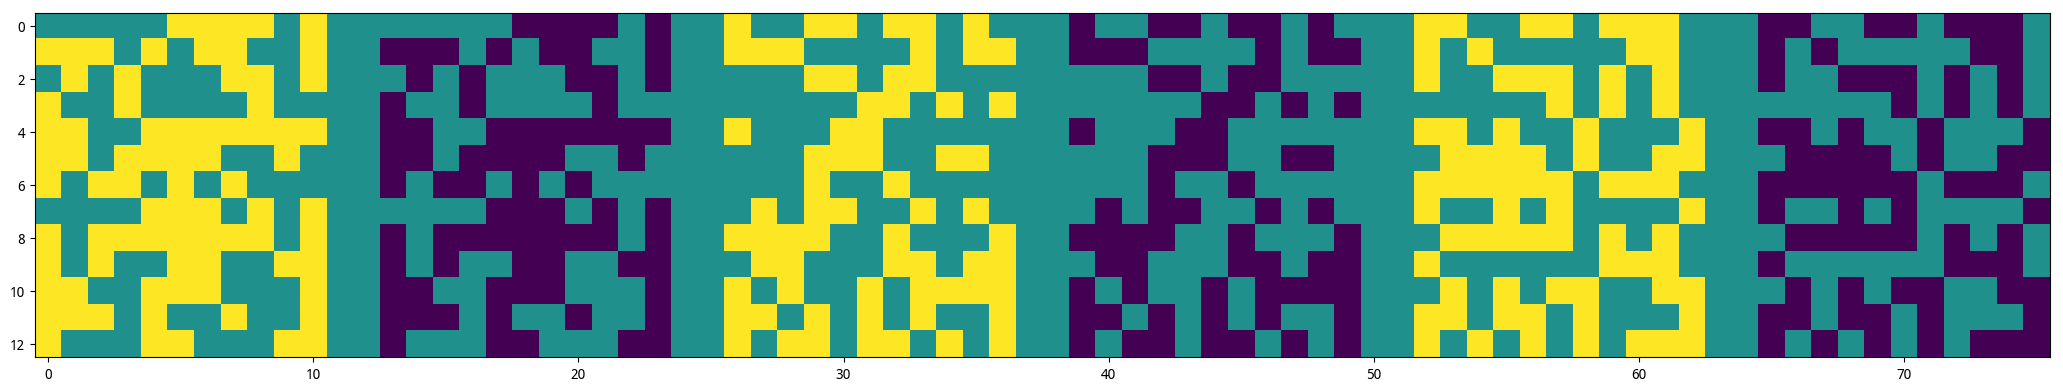

In [12]:
plt.figure(figsize=(26,8))
plt.imshow(test_inputs[0].T-test_targets[0].T, interpolation='none')
plt.show()

### test for repeat&copy

In [13]:
import os

class test_repeat_copy(DNC_Seq2Seq):
    
    def __init__(self, inputs, targets, hyperparameter):
        DNC_Seq2Seq.__init__(self, inputs, targets, hyperparameter)
        
    def loss_fit(self, pred, targets):
        #loss_tensor = -targets*tf.log(pred + 1e-31) - (1-targets)*tf.log(1-pred + 1e-31)
        loss_tensor = (pred - targets)**2
        return tf.reduce_mean(loss_tensor)
        
    def fit_clip(self, test_inputs, test_targets, learning_rate=1e-4, momentum=0.9, iterations=1e5, max_grad_norm = 50):      
        
        out_width = self.hyperparameter['out_width']
        tape = self._zero_state(self.hyperparameter)
        inputs_placeholder = tf.transpose(a=self.inputs_placeholder, perm=[1,0,2])          
        outputs_looping = tf.scan(fn=self._step, elems=inputs_placeholder, initializer=tape)[-1]
        
        output = tf.transpose(outputs_looping, [1,0,2])
        #pred = tf.sigmoid(output)
        pred = output

        cost = self.loss_fit(pred, self.targets_placeholder)   
        
        optimizer = tf.train.RMSPropOptimizer(learning_rate, momentum=momentum)
        gradients = optimizer.compute_gradients(cost)
        for i, (grad, var) in enumerate(gradients):
            if grad is not None:
                gradients[i] = (tf.clip_by_value(grad, -5, 5), var)
        grad_op = optimizer.apply_gradients(gradients)

        correct_pred = tf.equal(tf.round(pred), self.targets_placeholder)
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        init = tf.global_variables_initializer()

        #tf.summary.scalar('generalization error', test)
        tf.summary.scalar("loss", cost)
        tf.summary.scalar("accuracy", accuracy)
        merged_summary_op = tf.summary.merge_all()
        # 绝对路径
        logs_path = os.path.join(os.getcwd(),"logdata")
        
        tmp = []
        with tf.Session() as sess:
            sess.run(init)
            summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
            for i in range(np.int(iterations)):
                _, loss = sess.run([grad_op, cost], feed_dict={self.inputs_placeholder:self.inputs, self.targets_placeholder:self.targets})
                tmp.append(loss)
                #_, summary = sess.run([grad_op, merged_summary_op], feed_dict={self.inputs_placeholder:self.inputs, self.targets_placeholder:self.targets})
                #summary_writer.add_summary(summary, i)
            print ("Optimization Finished!")
            return tmp
            

In [14]:
train_inputs.shape

(32, 76, 13)

In [15]:
hyperparameter = {}
hyperparameter['batch_size'] = 32
hyperparameter['in_length'] =76
hyperparameter['in_width'] = 13
hyperparameter['out_length'] = 76
hyperparameter['out_width'] = 13
hyperparameter['hidden_num'] = 20
hyperparameter['memory_N'] = 20
hyperparameter['memory_W'] = 13
hyperparameter['read_head_num'] = 3

test = test_repeat_copy(train_inputs, train_targets, hyperparameter)

tf.trainable_variables()

In [16]:
test_pred = test.fit_clip(test_inputs, test_targets, iterations=1e3, learning_rate=1e-4)

Optimization Finished!


In [17]:
import pandas as pd

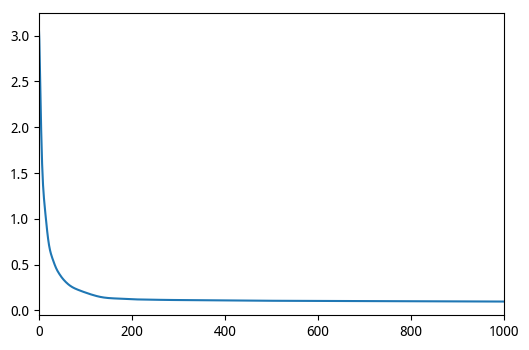

In [18]:
p = pd.Series(test_pred)
p.plot()

In [19]:
p

0      3.093870
1      2.959617
2      2.738933
3      2.474893
4      2.211662
5      1.970040
6      1.765759
7      1.599944
8      1.469898
9      1.368302
10     1.288251
11     1.222068
12     1.164127
13     1.110253
14     1.057896
15     1.006410
16     0.955789
17     0.906541
18     0.859613
19     0.815935
20     0.775606
21     0.739777
22     0.708141
23     0.680477
24     0.656627
25     0.635303
26     0.616657
27     0.599777
28     0.584136
29     0.568970
         ...   
970    0.096087
971    0.096159
972    0.096065
973    0.095920
974    0.096079
975    0.095961
976    0.095913
977    0.095998
978    0.095767
979    0.095845
980    0.095932
981    0.095816
982    0.095876
983    0.095781
984    0.096068
985    0.096089
986    0.095928
987    0.095899
988    0.095794
989    0.095790
990    0.095926
991    0.095752
992    0.095691
993    0.095662
994    0.095728
995    0.095792
996    0.095683
997    0.095791
998    0.095689
999    0.095550
dtype: float64